# Задание 1. A/B–тестирование

In [418]:
#Загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm
from scipy.stats import norm 
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as ss

from matplotlib import pyplot as plt
import warnings
from scipy.stats import bootstrap

import re

In [419]:
#Загрузим исходные данные
df_groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_groups.csv', sep=';')
df_groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_group_add.csv')
df_active_studs= pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_active_studs.csv')
df_checks=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_checks.csv', sep=';')

In [420]:
#Детально рассмотрим данные
#Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
df_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [421]:
df_groups.shape

(74484, 2)

In [422]:
df_groups.dtypes

id      int64
grp    object
dtype: object

In [423]:
df_groups.id.nunique()

74484

In [424]:
#Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
df_groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [425]:
df_groups_add.shape

(92, 2)

In [426]:
df_groups_add.dtypes

id      int64
grp    object
dtype: object

In [427]:
df_groups_add.id.nunique()

92

In [428]:
#Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
df_active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [429]:
df_active_studs.shape

(8341, 1)

In [430]:
df_active_studs.dtypes

student_id    int64
dtype: object

In [431]:
df_active_studs.student_id.nunique()

8341

In [432]:
#Файл с информацией об оплатах пользователей в дни проведения эксперимента. 
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [433]:
df_checks.isna().value_counts()

student_id  rev  
False       False    541
dtype: int64

In [434]:
df_checks.shape

(541, 2)

In [435]:
df_checks.dtypes

student_id      int64
rev           float64
dtype: object

In [436]:
df_checks.student_id.nunique()

541

In [437]:
# Так как согласно предоставленной информации df_groups_add является дополнительным файл с пользователями, который нам прислали 
# спустя 2 дня после передачи данных то добавим данные в таблицу df_groups
df_groups_all = pd.concat([df_groups, df_groups_add])

In [438]:
# Проверим результат
df_groups_all.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [439]:
df_groups_all.shape

(74576, 2)

In [440]:
# df_groups(74484) + df_groups_add(92) = df_groups_all(74576) Добавление данных прошло успешно.

In [441]:
count_df_groups_all = df_groups_all.grp.value_counts()
count_df_groups_all = pd.DataFrame(count_df_groups_all)
count_df_groups_all

,grp
B,59883
A,14693


In [442]:
# Из данных выше мы видим что группы разбиты не равномерно, это указывает нам на ошибки которые имеются в программе 
# распределения пользователей (система сплитования).

In [443]:
# Далее посмотрим пользователей которые заходили на площадку и совершили оплату для этого нам понадобятся данные 
# df_active_studs и df_checks

In [444]:
df_active_check = df_active_studs.merge(df_checks.drop_duplicates(), on=['student_id'], how='left', indicator=True)
df_active_check.shape

(8341, 3)

In [445]:
# Количество активных пользователей, которые зашли на платформу в дни проведения эксперимента и не совершили оплаты.
df_active_check_no = df_active_check.query('_merge == "left_only"')
df_active_check_no.shape

(7949, 3)

In [446]:
# Количество активных пользователей, которые зашли на платформу в дни проведения эксперимента и совершили оплаты.
df_active_check_yes = df_active_check.query('_merge == "both"')
df_active_check_yes = df_active_check_yes.drop(columns='_merge')
df_active_check_yes['rev'] = round(df_active_check_yes['rev'],0)
df_active_check_yes.shape

(392, 2)

In [447]:
# Найдем количество пользователей которые не заходили на платформу в дни проведения эксперимента и совершили оплаты. 
# Возможно у них стои овто платеж.
df_no_active_check = df_checks.merge(df_active_check_yes.drop_duplicates(), on=['student_id'], how='left', indicator=True)

In [448]:
df_no_active_check.shape

(541, 4)

In [449]:
df_no_active_check_yes = df_no_active_check.query('_merge == "left_only"')\
                                           .drop(columns=['rev_y','_merge'])\
                                           .rename(columns={'rev_x':'rev'})
df_no_active_check_yes.shape

(149, 2)

In [450]:
# Найдем количество активных пользователей совершивших оплату в дни проведения эксперимента по группам
count_active_check_yes = df_groups_all.query('id in @df_active_check_yes.student_id').grp.value_counts()
count_active_check_yes = pd.DataFrame(count_active_check_yes)
count_active_check_yes

,grp
B,314
A,78


In [451]:
# Найдем количество активных пользователей не совершивших оплату в дни проведения эксперимента по группам
count_active_check_no = df_groups_all.query('id in @df_active_check_no.student_id').grp.value_counts()
count_active_check_no = pd.DataFrame(count_active_check_no)
count_active_check_no

,grp
B,6489
A,1460


In [452]:
# Найдем количество не активных пользователей совершивших оплату в дни проведения эксперимента по группам
count_no_active_check_yes = df_groups_all.query('id in @df_no_active_check_yes.student_id').grp.value_counts()
count_no_active_check_yes = pd.DataFrame(count_no_active_check_yes)
count_no_active_check_yes

,grp
B,120
A,29


In [453]:
# Найдем количество не активных пользователей не совершивших оплату в дни проведения эксперимента по группам
df_no_active_check_no = df_groups_all.rename(columns={'id':'student_id'})\
                                     .merge(df_active_studs.drop_duplicates(), on=['student_id'], how='left', indicator=True)\
                                     .query('_merge=="left_only"')\
                                     .drop(columns='_merge')\
                                     .merge(df_checks.drop_duplicates(), on=['student_id'], how='left', indicator=True)\
                                     .query('_merge=="left_only"')\
                                     .drop(columns='_merge')\
                                     .drop(columns='rev').grp.value_counts()
df_no_active_check_no = pd.DataFrame(df_no_active_check_no)
df_no_active_check_no

,grp
B,52960
A,13126


In [454]:
#Создадим промежуточную таблицу для промежутоных выводов
general_table = pd.DataFrame()

In [455]:
general_table['groups_all'] = count_df_groups_all.grp

In [456]:
general_table['df_no_active_check_no'] = df_no_active_check_no.grp

In [457]:
general_table['count_active_check_no'] = count_active_check_no.grp

In [458]:
general_table['count_active_check_yes'] = count_active_check_yes.grp

In [459]:
general_table['count_no_active_check_yes'] = count_no_active_check_yes.grp

In [460]:
general_table

,groups_all,df_no_active_check_no,count_active_check_no,count_active_check_yes,count_no_active_check_yes
B,59883,52960,6489,314,120
A,14693,13126,1460,78,29


In [461]:
# Из таблицы выше мы видим что есть активные пользователи т.е. те кто заходили на сайт в дни проведения теста. Небольшое
# количество активных пользователей совершили платежи, также платежи совершили не активные пользователи. Не совсем понятно
# что за пользователи кто не активный но совершил платеж? Из постановки задачи это не ясно, возможно это автоматические платежи, 
# а возможно сбой системы и все оплатившие являются активными. У нас нет возможности проверить данную информацию поэтому мы
# рассмотрим тех, кто одновременно является и оплатившим, и активным (df_active_check_yes-392 человека).

In [462]:
# Выберем активных пользователей и посмотрим к какой группе они относятся.
df_active = df_active_check.drop(columns = '_merge')\
                           .rename(columns = {'student_id':'id'})\
                           .merge(df_groups_all, on = 'id', how = 'left')
df_active.head()

,id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


In [463]:
#Добавим колонку с группами оплатил = 1/ не оплатил = 0
df_active['payment'] = df_active.rev.apply(lambda x: 0 if np.isnan(x) else 1)
df_active = df_active.fillna(0)
df_active

,id,rev,grp,payment
0,581585,0.0,A,0
1,5723133,0.0,A,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0
...,...,...,...,...
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1


In [464]:
# Посмотрим занимаемые части активных - оплативших пользователей и активных - не оплативших  
# Сначало посмотрим на группу А
df_grp_A_norm = df_active.query('grp == "A"')
df_grp_A_norm.payment.value_counts(normalize=True).mul(100)

0    94.928479
1     5.071521
Name: payment, dtype: float64

In [465]:
fig0 = px.histogram(df_grp_A_norm, x='payment')
fig0.show()

In [466]:
# Далее посмотрим на группу В
df_grp_B_norm = df_active.query('grp == "B"')
df_grp_B_norm.payment.value_counts(normalize=True).mul(100)

0    95.384389
1     4.615611
Name: payment, dtype: float64

In [467]:
fig0 = px.histogram(df_grp_B_norm, x='payment')
fig0.show()

In [468]:
df_active.groupby('grp').agg({'rev':'count'})

,rev
grp,
A,1538
B,6803


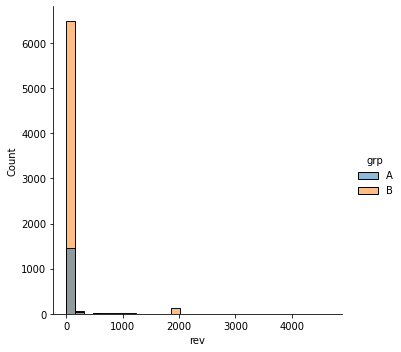

In [469]:
sns.displot(data=df_active, x="rev", hue="grp",bins=30)

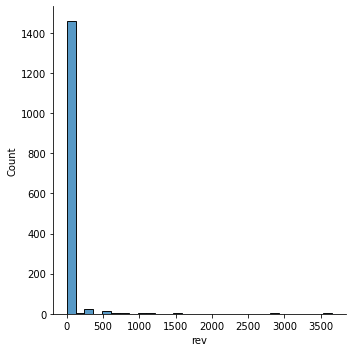

In [470]:
df_grp_A_norm_grf = sns.displot(data=df_active[df_active.grp == 'A'], x="rev",bins=30)

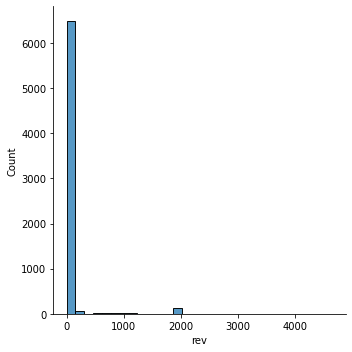

In [471]:
df_grp_B_norm_grf = sns.displot(data=df_active[df_active.grp == 'B'], x="rev",bins=30)

In [472]:
#Далее посмотрим описательную статистику двух групп и попытаемся описать что мы видим
statistic_activ = pd.concat([df_grp_A_norm.rev.describe().to_frame().rename(columns = {'rev':'groupA'}),\
                             df_grp_B_norm.rev.describe().to_frame().rename(columns = {'rev':'groupB'})],axis = 1)
statistic_activ['rercent'] = (statistic_activ.groupB / statistic_activ.groupA * 100) - 100
statistic_activ

,groupA,groupB,rercent
count,1538.000000,6803.000000,342.327698
mean,47.347204,58.058798,22.623498
std,290.490632,313.770201,8.013879
min,0.000000,0.000000,NaN
25%,0.000000,0.000000,NaN
50%,0.000000,0.000000,NaN
75%,0.000000,0.000000,NaN
max,3660.000000,4650.000000,27.049180


In [473]:
# Количество в эксперементальной группе значительно больше чем в контрольной больше в 342,32%
# Из значений выше мы видим что среднее значение цены покупки выросло на 22,62% 
# Стандартное отклонение тоже выросло на 8,01% 
# Максимальная сумма оплаты тоже стала больше на 27,04%

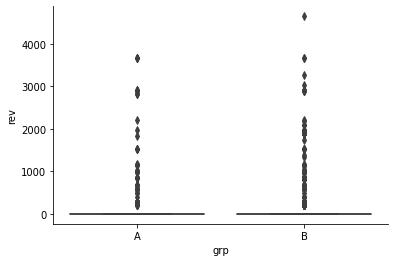

In [474]:
# Посмотрим на выбросы
sns.boxplot(data=df_active, y='rev', x='grp')
sns.despine()

In [475]:
# Далее выполним все тоже самое, и возьмем только оплативших пользователей 
df_grp_AB = df_active.query('rev > 0')
df_grp_A = df_active.query('grp == "A"').query('rev > 0')
df_grp_B = df_active.query('grp == "B"').query('rev > 0')

In [476]:
df_grp_AB.groupby('grp').agg({'rev':'count'})

,rev
grp,
A,78
B,314


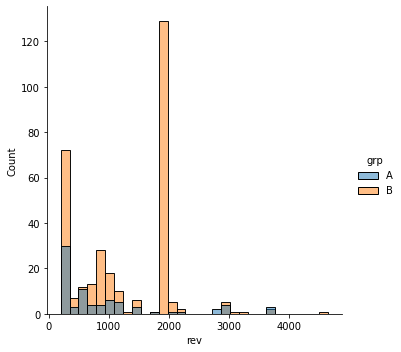

In [477]:
sns.displot(data=df_grp_AB, x="rev", hue="grp",bins=30)

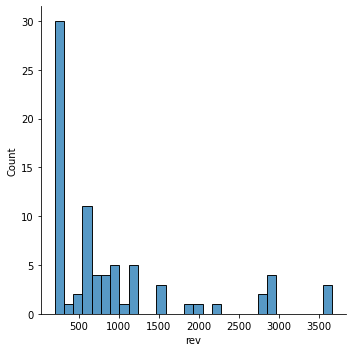

In [478]:
sns.displot(data=df_grp_AB[df_grp_AB.grp == 'A'], x="rev",bins=30)

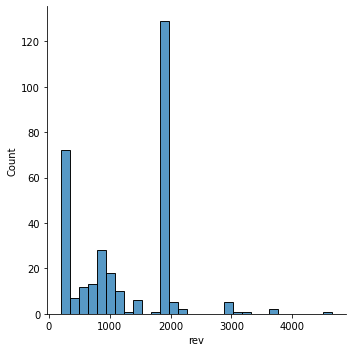

In [479]:
df_test = sns.displot(data=df_grp_AB[df_grp_AB.grp == 'B'], x="rev",bins=30)

In [480]:
# Посчитаем среднее значение
statistic_activ_pay = pd.concat([df_grp_A.rev.describe().to_frame().rename(columns = {'rev':'groupA'}),\
                             df_grp_B.rev.describe().to_frame().rename(columns = {'rev':'groupB'})],axis = 1)
statistic_activ_pay['rercent'] = (statistic_activ_pay.groupB / statistic_activ_pay.groupA * 100) - 100
statistic_activ_pay

,groupA,groupB,rercent
count,78.000000,314.000000,302.564103
mean,933.589744,1257.878992,34.735734
std,919.932711,790.864254,-14.030206
min,199.000000,199.000000,0.000000
25%,290.000000,511.750000,76.465517
50%,585.000000,1140.000000,94.871795
75%,1114.750000,1900.000000,70.441803
max,3660.000000,4650.000000,27.049180


In [481]:
# Количество в эксперементальной группе значительно больше чем в контрольной больше в 302,56%
# Из значений выше мы видим что среднее значение цены покупки выросло на 34,73% 
# Стандартное отклонение уменьшилось на 14,03% 
# Максимальная сумма оплаты тоже стала больше на 27,04%

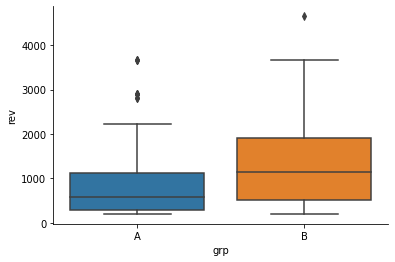

In [482]:
df_active_pay = df_active.query('rev > 0')
sns.boxplot(data=df_active_pay, y='rev', x='grp')
sns.despine()

In [483]:
# Для любого продукта есть несколько главных составляющих которые мы и посчитаем, на основе этих данных в дальнейшем мы сможем
# разработать стратегию:
# 1) Первым делом мы посмотрим, retantion rate;
# 2) Далее мы посмотрим конверсию СR в покупателя;
# 3) Сравним показатели 2 групп.

In [484]:
count_active = count_active_check_no + count_active_check_yes
cr_table = pd.concat([count_df_groups_all.rename(columns={'grp':'df_groups_all'}),\
           count_active.rename(columns={'grp':'active'}),\
           count_active_check_yes.rename(columns={'grp':'active_check_yes'})], axis = 1)
cr_table

,df_groups_all,active,active_check_yes
B,59883,6803,314
A,14693,1538,78


In [485]:
cr_table['retaition_rate'] = round((cr_table.active / cr_table.df_groups_all)*100,2)
cr_table['cr'] = round((cr_table.active_check_yes / cr_table.active)*100,2)

In [486]:
cr_table

,df_groups_all,active,active_check_yes,retaition_rate,cr
B,59883,6803,314,11.36,4.62
A,14693,1538,78,10.47,5.07


In [487]:
new_order = ['df_groups_all', 'retaition_rate', 'active', 'cr', 'active_check_yes']
cr_table = cr_table.reindex(columns = new_order)
cr_table

,df_groups_all,retaition_rate,active,cr,active_check_yes
B,59883,11.36,6803,4.62,314
A,14693,10.47,1538,5.07,78


In [488]:
diff_retaition_rate_table = round((cr_table.retaition_rate[0]-cr_table.retaition_rate[1])/cr_table.retaition_rate[1],4)
diff_retaition_rate_table1 = diff_retaition_rate_table
diff_retaition_rate_table = '{:.1%}'.format(diff_retaition_rate_table)
diff_retaition_rate_table

'8.5%'

In [489]:
diff_cr_table = (cr_table.cr[0]-cr_table.cr[1])/cr_table.cr[1]
diff_cr_table1 = diff_cr_table
diff_cr_table = '{:.1%}'.format(diff_cr_table)
diff_cr_table

'-8.9%'

In [490]:
print('Коэффициент удержания группы А:', cr_table.retaition_rate[1])
print('Коэффициент удержания группы B:', cr_table.retaition_rate[0])
print('Коэффициент удержания группы В отличается от группы А на:', diff_retaition_rate_table)

Коэффициент удержания группы А: 10.47
Коэффициент удержания группы B: 11.36
Коэффициент удержания группы В отличается от группы А на: 8.5%


In [491]:
print('Конверсия в покупателя группы А:', cr_table.cr[1])
print('Конверсия в покупателя группы B:', cr_table.cr[0])
print('Конверсия в покупателя группы В отличается от группы А на:', diff_cr_table)

Конверсия в покупателя группы А: 5.07
Конверсия в покупателя группы B: 4.62
Конверсия в покупателя группы В отличается от группы А на: -8.9%


In [492]:
# Делее посмотрим на показатель - Общий доход / Количество активных пользователей за период(ARPAU):
ARPAU_group_A = round(statistic_activ.groupA[1],2)
ARPAU_group_A

47.35

In [493]:
ARPAU_group_B = round(statistic_activ.groupB[1],2)
ARPAU_group_B

58.06

In [494]:
# Сравним показатели ARPPU двух групп:
diff_ARPAU = (ARPAU_group_B - ARPAU_group_A) / ARPAU_group_A
diff_ARPAU = '{:.1%}'.format(diff_ARPAU)
diff_ARPAU

'22.6%'

In [495]:
print('ARPAU группы А:', ARPAU_group_A)
print('ARPAU группы B:', ARPAU_group_B)
print('ARPAU группы В отличается от группы А на:', diff_ARPAU)

ARPAU группы А: 47.35
ARPAU группы B: 58.06
ARPAU группы В отличается от группы А на: 22.6%


In [496]:
# Делее посмотрим на показатель - Общий доход за период / Количество платящих пользователей за период(ARPPU):
ARPPU_group_A = round(statistic_activ_pay.groupA[1],2)
ARPPU_group_A

933.59

In [497]:
ARPPU_group_B = round(statistic_activ_pay.groupB[1],2)
ARPPU_group_B

1257.88

In [498]:
# Сравним показатели ARPPU двух групп:
diff_ARPPU = (ARPPU_group_B - ARPPU_group_A) / ARPPU_group_A
diff_ARPPU = '{:.1%}'.format(diff_ARPPU)
diff_ARPPU

'34.7%'

In [499]:
print('ARPPU группы А:', ARPPU_group_A)
print('ARPPU группы B:', ARPPU_group_B)
print('ARPPU группы В отличается от группы А на:', diff_ARPPU)

ARPPU группы А: 933.59
ARPPU группы B: 1257.88
ARPPU группы В отличается от группы А на: 34.7%


In [500]:
# Это все метрики которые мы можем посчитать из предоставленных данных, т.к. LTV (Lifetime Value) - 
# (продолжительность пользования продуктом) x ARPU или AOV x lifetime x RPR (Repeat Purchase Rates, число повторных покупок) или 
# Общий доход / Количество заказов - нет данных для подсчета этих показателей.

In [501]:
# Опишем данные которые мы видим из расчитанного выше и сделаем предварительные выводы:
# Наблюдаем отрицательный эффект CR, и положительные эффекты в ARPU и ARPPU. Другими словами, конверсия падает, но доход 
# на пользователя/покупателя растёт. Это означает что покупателей становится меньше, при этом их средний чек растет, можем 
# предположить что эти вещи взаимосвязаны и из-за увеличения стоимости количество активных пользователей стало меньше. 

In [502]:
# Далее посмотрим являются ли эти значения статистически значимыми.
# СR
# Сформулируем нулевую и альтернативную гипотезы:
# H0: СR в двух группах одинаковые.
# H1: СR в двух группах различаются.

In [504]:
# Посмотрим на конверсию в наших группах
# Ранее мы уже ее считали так что просто подгрузим значение

In [524]:
df_active_cr = df_active

In [518]:
print(df_active_cr.grp.value_counts())

B    6803
A    1538
Name: grp, dtype: int64


In [519]:
df_active_cr = pd.crosstab(df_active_cr.grp, df_active_cr.payment)
df_active_cr

payment,0,1
grp,,
A,1460,78
B,6489,314


In [520]:
# Мы видим разницу в конверсии по группам.

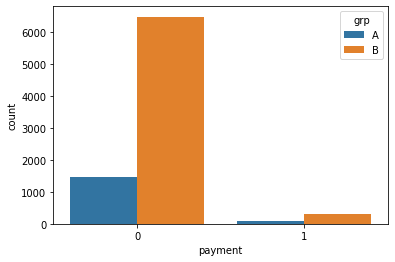

In [521]:
# Построим график конверсии
sns.countplot(x="payment", hue="grp", data = df_active)
plt.show()

In [522]:
# Проверим зависит ли конверсия от принадлежности к группе.
# Т.к. у нас две номенативные переменные (принадлежность к группе и наличие покупки) я буду испльзовать ХИ квадрат Пирсона
# Н0 - связи между конверсией и групповой принадлежностью нет

In [523]:
stat, p, dof, expected = stats.chi2_contingency(df_active_cr)
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print('p-value =', round(stat, 2)) 

p-value = 0.48


In [ ]:
# p-value > 0.05 не отклоняем Н0 о том, что связи между конверсиией и принадлежности нет.

In [ ]:
# Считаем далее
# Из графиков которые мы рисовали ранее мы видим, что наши распределения далеки от нормальных, а значит применение Т-теста 
# недопустимо. Можно было логарифмировать наши данные и наши распределения стали бы похожи на нормальные, но это приведет 
# к трудностям в интерпретации для бизнеса. По этой же причине я не стал применять непараметрический U-критерий Манна — Уитни.
# В данной ситуации считаю оптимальным применение Бутсрапа.

In [255]:
# ARPАU
# Сформулируем нулевую и альтернативную гипотезы:
# H0: ARPАU в двух группах одинаковые.
# H1: ARPАU в двух группах различаются.

In [256]:
df_active_control = df_active[df_active.grp == 'A']
df_active_test = df_active[df_active.grp == 'B']

In [257]:
df_active_control.rev.mean()

47.34720416124838

In [258]:
df_active_test.rev.mean()

58.05879810377775

In [259]:
mean_active_diff = []

for i in range(10000):
    sample_data_active_control = df_active_control.sample(frac=1, replace=True)
    sample_mean_active_control = sample_data_active_control.rev.mean()
    
    
    sample_data_active_test = df_active_test.sample(frac=1, replace=True)
    sample_mean_active_test = sample_data_active_test.rev.mean()
    
    sample_mean_diff = sample_mean_active_test - sample_mean_active_control
    mean_active_diff.append(sample_mean_diff)

In [260]:
pd.Series(mean_active_diff).quantile(0.975)

26.47493594913186

In [261]:
pd.Series(mean_active_diff).quantile(0.025)

-6.06047391292747

In [262]:
# Доверительный интервал попадает в 0, недостаточно оснований отвергнуть нулевую гипотезу.
# Нельзя утверждать, что различия ARPAU в двух группах есть.

In [263]:
# ARPPU
# Сформулируем нулевую и альтернативную гипотезы:
# H0: ARPPU в двух группах одинаковые.
# H1: ARPPU в двух группах различаются.

In [264]:
df_control = df_grp_AB[df_grp_AB.grp == 'A']
df_test =  df_grp_AB[df_grp_AB.grp == 'B']

In [265]:
df_control.rev.mean()

933.5897435897435

In [266]:
df_test.rev.mean()

1257.8789920382164

In [267]:
mean_diff = []

for i in range(10000):
    sample_data_control = df_control.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.rev.mean()
    
    
    sample_data_test = df_test.sample(frac=1, replace=True)
    sample_mean_test = sample_data_test.rev.mean()
    
    sample_mean_diff = sample_mean_test - sample_mean_control
    mean_diff.append(sample_mean_diff)

In [268]:
pd.Series(mean_diff).quantile(0.975)

533.9049553872691

In [269]:
pd.Series(mean_diff).quantile(0.025)

93.69917135186992

In [270]:
# Доверительный интервал не проходит через 0, достаточно оснований отвергнуть нулевую гипотезу.
# Можем утверждать, что различия ARPPU в двух группах есть.

In [321]:
# Исходя из полученных данных делаем вывод что нужно внедрять новую механику оплаты, значимого эффекта на показатели СR и ARPАU
# как предполагалось мной ранее не подтвердилось, значительно увеличись только показатели ARPPU. 
# ХИ-квадрат Пирсона для проверки конверсии в покупку, бутсрап для сравнения средних показали отсутствие статистически значимых
# различий.
# Бутсрап для сравнения ARPPU показал, что статистически значимые различия в группах есть.
# Т.к. ARPPU целевой группы больше на 34.7% стоит запускать новую механику оплаты на всех пользователей.

# 2 Задние SQL

In [525]:
import pandahouse as ph

connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


# группируем студентов, по st_id и фильтруем по тем которые выполниили хотя бы 20 заданий (горошин) за месяц

q = """
SELECT st_id, SUM(correct)
FROM default.peas
GROUP BY st_id
HAVING SUM(correct) >= 20
"""

ph.read_clickhouse(query=q, connection=connection_default)

,st_id,sum(correct)
0,700123,126
1,171209,26
2,219630,53
3,416918,26
4,877738,22
...,...,...
131,375731,24
132,71465,38
133,936163,29
134,790532,22


In [526]:
# последний пункт
# дубликатов нет в final_project_check
# ARPU - доход за период / количество всех пользователей
# ARPAU - доход за период / количество всех пользователей, решивших более 10 задач
# CR в покупку - количество пользователей сделавших покупку / количество пользователей
# CR активного пользователя в покупку - количество пользователей сделавших покупку / количество всех пользователей, решивших более 10 задач
# CR в покупку - количество пользователей сделавших покупку курса по математике / количество всех пользователей, решивших более 2 задач по математике


q = """
WITH active_users AS 
    (
     SELECT DISTINCT st_id
     FROM peas
     GROUP BY st_id
     HAVING SUM(correct) >= 10
     ),
    active_users_math AS 
     (
     SELECT DISTINCT st_id
     FROM peas
     WHERE subject = 'Math'
     GROUP BY st_id
     HAVING SUM(correct) >= 2
     ),
     pilot_users AS
     (
     SELECT st_id
     FROM default.studs
     WHERE test_grp = 'pilot'
     ),
     control_users AS
     (
     SELECT st_id
     FROM default.studs
     WHERE test_grp = 'control'
     )

SELECT sumIf(money, st_id IN pilot_users) / (SELECT COUNT() FROM pilot_users) AS ARPU_pilot,
       sumIf(money, st_id IN control_users) / (SELECT COUNT() FROM control_users) AS ARPU_control,
       sumIf(money, st_id IN active_users AND st_id IN pilot_users) / (SELECT COUNT() FROM pilot_users WHERE st_id in active_users) AS ARPAU_pilot,
       sumIf(money, st_id IN active_users AND st_id IN control_users) / (SELECT COUNT() FROM control_users WHERE st_id in active_users) AS ARPAU_control,
       countIf(st_id, st_id IN pilot_users) / (SELECT COUNT() FROM pilot_users) AS CR_pilot,
       countIf(st_id, st_id IN control_users) / (SELECT COUNT() FROM control_users) AS CR_control,
       countIf(st_id, st_id IN active_users AND st_id IN pilot_users) / (SELECT COUNT() FROM pilot_users WHERE st_id in active_users) AS CR_active_pilot,
       countIf(st_id, st_id IN active_users AND st_id IN control_users) / (SELECT COUNT() FROM control_users WHERE st_id in active_users) AS CR_active_control,
       countIf(st_id, st_id IN active_users_math AND st_id IN pilot_users) / (SELECT COUNT() FROM pilot_users WHERE st_id in active_users_math) AS CR_active_math_pilot,
       countIf(st_id, st_id IN active_users_math AND st_id IN control_users) / (SELECT COUNT() FROM control_users WHERE st_id in active_users_math) AS CR_active_math_control
FROM default.final_project_check
"""

ph.read_clickhouse(query=q, connection=connection_default)

,ARPU_pilot,ARPU_control,ARPAU_pilot,ARPAU_control,CR_pilot,CR_control,CR_active_pilot,CR_active_control,CR_active_math_pilot,CR_active_math_control
0,11508.474576,4540.983607,28267.326733,10000.0,0.145763,0.059016,0.346535,0.128788,0.238095,0.122449


# 3 Задание 3. Python

In [537]:
df_groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_groups.csv', sep=';')
df_groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_group_add.csv')
df_active_studs= pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_active_studs.csv')
df_checks=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_checks.csv', sep=';')

In [538]:
# получим датафрейм с общей информацией об активности пользователя и информации об оплате

df_active_studs.columns = ['id']
df_active_studs['active'] = 1
df_active_studs['active'] = df_active_studs['active'].astype('Int64')
df_checks.columns = ['id', 'rev']

df_groups = df_groups.merge(df_active_studs, how='left', on='id')
df_groups = df_groups.merge(df_checks, how='left', on='id')

# заменим на 0 неопределенные значения (нет активности и нет покупок)
df_groups.fillna(0, inplace=True)

In [547]:
# напишем необходимые функции
def get_cr(x):
    return sum(x) / len(x)

def get_arpu(y):
    return np.mean(y)

def get_arppu(y):
    return np.mean(y)

def get_metrics(df_groups, 
                group_add_filepath,
                df_active_studs_filepath = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_active_studs.csv',
                df_checks_filepath = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_checks.csv'
                ):
    '''
    Основная функция:
    - объединяет дополнительный файл с основным датафреймом
    - считает метрики ARPU, ARPPU, CR
    '''
    # считаем все файлы для аггрегации
    df_groups_add = pd.read_csv(group_add_filepath)
    df_active_studs = pd.read_csv(df_active_studs_filepath)
    df_checks = pd.read_csv(df_checks_filepath, sep=';')
    
    # приведем столбцы к единому формату
    df_active_studs.columns = ['id']
    df_active_studs['active'] = 1
    df_active_studs['active'] = df_active_studs['active'].astype('Int64')
    df_checks.columns = ['id', 'rev']

    # объединим со вспомогательными таблицами
    df_groups_add = df_groups_add.merge(df_active_studs, how='left', on='id')
    df_groups_add = df_groups_add.merge(df_checks, how='left', on='id')
    df_groups_add.fillna(0, inplace=True)

    # объединим с предыдущей полученной таблицей
    df_groups = pd.concat([df_groups, df_groups_add])

    # считаем метрики
    result = []
    for grp in ['A', 'B']:
        arpu = get_arpu(df_groups[df_groups['grp'] == grp].rev.tolist())
        arppu = get_arppu(df_groups[(df_groups['grp'] == grp) & (df_groups['rev'] > 0)].rev.tolist())
        cr = get_cr(df_groups[df_groups['grp'] == grp].active.tolist())
        result.append([arpu, arppu, cr])

    return pd.DataFrame(result, index = ['A', 'B'], columns = ['ARPU', 'ARPPU', 'CR'])

In [548]:
users_metrics = get_metrics(df_groups, '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-zagorodnyh-38/Проект_2_group_add.csv')

In [549]:
def plot_metrics(users_metrics):
    '''
    строим графики по полученным метрикам
    '''
    figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))  
    figure.suptitle('Метрики', fontsize=20)
    
    ax1.plot([0,1], users_metrics['ARPU'].tolist())
    ax1.set_xlabel('ARPU value', fontsize=15)
    
    ax2.plot([0,1], users_metrics['ARPPU'].tolist())
    ax2.set_xlabel('ARPPU value', fontsize=15)

    ax3.plot([0,1], users_metrics['CR'].tolist())
    ax3.set_xlabel('CR value', fontsize=15)

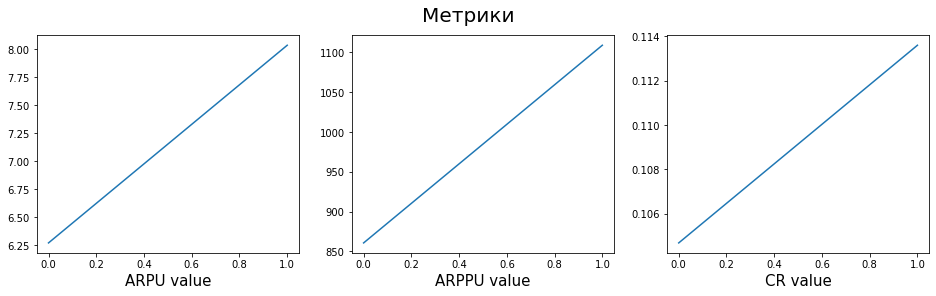

In [550]:
plot_metrics(users_metrics)